# Text processing

## Init spark

In [2]:
from utils.setup import *
# import findspark
# findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc = SparkContext(conf=SparkConf())
spark = SparkSession(sparkContext=sc)

## Read data

In [7]:
import os, errno
import pandas as pd
from pyspark import SparkContext, SparkConf, Row
from pyspark.sql import SparkSession

books_rdd_list = []
directory = r'data/'
for filename in os.listdir(directory)[:20]:
    txt = open("data/"+filename, mode='r', errors='ignore').read()
    row = Row(id=filename.replace('.txt',''), texts=txt)
    books_rdd_list.append(row)
    
rdd = sc.parallelize(books_rdd_list)
df = rdd.flatMap(lambda x: (x,)).toDF()
df.show(3)

+-------+--------------------+
|     id|               texts|
+-------+--------------------+
|38713-8|The Project Guten...|
|50195-0|﻿The Project Gute...|
|48695-0|﻿The Project Gute...|
+-------+--------------------+
only showing top 3 rows



## Get title of book

In [8]:
%%time
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def get_title(book):
    pattern = r'Title\: (.*?)([\\n]*?)Author'
    title = re.search(pattern, 
                      book.encode('unicode_escape').decode()).group(1)
    title = title.replace(r'\n','') # remove newline sign
    title = re.sub(' +', ' ', title)
    return title

titler = udf(get_title, returnType=StringType())

df = df.withColumn("title", titler("texts"))
df.select('title').show(3, False)

+----------------------------------------+
|title                                   |
+----------------------------------------+
|Old Church Lore                         |
|Practical Etiquette                     |
|The Stag Cook Book Written for Men by Me|
+----------------------------------------+
only showing top 3 rows

CPU times: user 10.8 ms, sys: 566 µs, total: 11.3 ms
Wall time: 264 ms


## Clean text

In [9]:
%%time
import unidecode
from gutenberg.cleanup import strip_headers

def clean(text):
    text = strip_headers(text).strip()
    text = unidecode.unidecode(text) # remove accents
    text = text.lower()
    text = text.replace(r'\n','') # remove newline sign
    text = re.sub(r'\d+', '', text) # remove digits 
    text = re.sub(r'[.]?-[.]?', '', text) # concatenate divided words
    text = re.sub(r'[\W]+',' ', text) # replace non-alphanum with space  
    text = re.sub(' +', ' ', text) # replace multiple spaces with single space 
    return text

user_def_fun = udf(f=clean, returnType=StringType())

df = df.withColumn("cleaned", user_def_fun("texts"))
df.show(2)
df = df.drop('texts')

+-------+--------------------+-------------------+--------------------+
|     id|               texts|              title|             cleaned|
+-------+--------------------+-------------------+--------------------+
|38713-8|The Project Guten...|    Old Church Lore|generously made a...|
|50195-0|﻿The Project Gute...|Practical Etiquette|practical etiquet...|
+-------+--------------------+-------------------+--------------------+
only showing top 2 rows

CPU times: user 9.11 ms, sys: 2.45 ms, total: 11.6 ms
Wall time: 924 ms


## Tokenization

In [10]:
%%time
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="cleaned", outputCol="tokens")
df = tokenizer.transform(df)
df.show(2)
df = df.drop('cleaned')

+-------+-------------------+--------------------+--------------------+
|     id|              title|             cleaned|              tokens|
+-------+-------------------+--------------------+--------------------+
|38713-8|    Old Church Lore|generously made a...|[generously, made...|
|50195-0|Practical Etiquette|practical etiquet...|[practical, etiqu...|
+-------+-------------------+--------------------+--------------------+
only showing top 2 rows

CPU times: user 102 ms, sys: 6.37 ms, total: 109 ms
Wall time: 2.25 s


## Stopwords Removal

In [11]:
%%time
from pyspark.ml.feature import StopWordsRemover

stopword_removal = StopWordsRemover(inputCol='tokens', 
                                    outputCol='refined_tokens')
df = stopword_removal.transform(df)
df.show(2)
df = df.drop('tokens')

+-------+-------------------+--------------------+--------------------+
|     id|              title|              tokens|      refined_tokens|
+-------+-------------------+--------------------+--------------------+
|38713-8|    Old Church Lore|[generously, made...|[generously, made...|
|50195-0|Practical Etiquette|[practical, etiqu...|[practical, etiqu...|
+-------+-------------------+--------------------+--------------------+
only showing top 2 rows

CPU times: user 58.7 ms, sys: 11.1 ms, total: 69.8 ms
Wall time: 2.42 s


## Stemming vs lemmatization

### SnowballStemmer

In [12]:
%%time
from nltk.stem.snowball import SnowballStemmer

def list_stemmer(words):
    stemmer = SnowballStemmer(language='english')
    return [stemmer.stem(word) for word in words]

stemming = udf(list_stemmer, returnType=ArrayType(StringType()))

df = df.withColumn("stem", stemming("refined_tokens"))
df.show(2)
# comment below line if you want to check also WordNetLemmatizer
df = df.drop("refined_tokens") 

+-------+-------------------+--------------------+--------------------+
|     id|              title|      refined_tokens|                stem|
+-------+-------------------+--------------------+--------------------+
|38713-8|    Old Church Lore|[generously, made...|[generous, made, ...|
|50195-0|Practical Etiquette|[practical, etiqu...|[practic, etiquet...|
+-------+-------------------+--------------------+--------------------+
only showing top 2 rows

CPU times: user 934 ms, sys: 135 ms, total: 1.07 s
Wall time: 6.37 s


## TF-IDF

In [13]:
%%time
from pyspark.ml.feature import HashingTF, IDF

hashing_vec = HashingTF(numFeatures=262144,
                        inputCol='stem',
                        outputCol='tf_features')

hashing_df = hashing_vec.transform(df)
hashing_df.select(['stem','tf_features']).show(2)

+--------------------+--------------------+
|                stem|         tf_features|
+--------------------+--------------------+
|[generous, made, ...|(262144,[58,169,2...|
|[practic, etiquet...|(262144,[216,352,...|
+--------------------+--------------------+
only showing top 2 rows

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 6.81 s


In [14]:
%%time
tf_idf_vec = IDF(inputCol='tf_features',
               outputCol='tf_idf_features')

tf_idf_df = tf_idf_vec.fit(hashing_df).transform(hashing_df)
tf_idf_df.select(['stem','tf_idf_features']).show(2)
tf_idf_df = tf_idf_df.drop(*['stem','tf_features']) 

+--------------------+--------------------+
|                stem|     tf_idf_features|
+--------------------+--------------------+
|[generous, made, ...|(262144,[58,169,2...|
|[practic, etiquet...|(262144,[216,352,...|
+--------------------+--------------------+
only showing top 2 rows

CPU times: user 25.3 ms, sys: 0 ns, total: 25.3 ms
Wall time: 25.9 s


# Reduction of dimensions
## PCA

### Explained variance for k principal components  

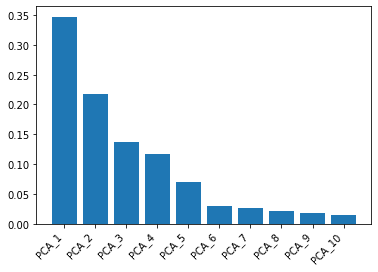

CPU times: user 394 ms, sys: 248 ms, total: 641 ms
Wall time: 4min 33s


In [15]:
%%time
from pyspark.ml.feature import PCA 
from pyspark.ml.linalg import Vectors

k = 10
pca = PCA(k=k, inputCol='tf_idf_features', outputCol="pca")
model = pca.fit(tf_idf_df)
exp_var = model.explainedVariance.values
plt.bar(['PCA_' + str(i+1) for i in range(exp_var.shape[0])], exp_var)
plt.xticks(rotation=45, ha='right')
plt.show()

### Dimensionality reduction

In [16]:
%%time

pca = PCA(k=2, inputCol='tf_idf_features', outputCol="pca")
model = pca.fit(tf_idf_df)
transformed = model.transform(tf_idf_df)
transformed.show(2) 
transformed = transformed.drop('tf_idf_features') 

+-------+-------------------+--------------------+--------------------+
|     id|              title|     tf_idf_features|                 pca|
+-------+-------------------+--------------------+--------------------+
|38713-8|    Old Church Lore|(262144,[58,169,2...|[-0.6442001827894...|
|50195-0|Practical Etiquette|(262144,[216,352,...|[-1.2466702802629...|
+-------+-------------------+--------------------+--------------------+
only showing top 2 rows

CPU times: user 43.4 ms, sys: 14.5 ms, total: 57.9 ms
Wall time: 4min 18s


### split vectors in to two columns

In [17]:
from pyspark.sql import Row
from pyspark.sql.types import *

two_columns_rdd = transformed.rdd.map(lambda x: Row(id=str(x[0]),
                                                    title=str(x[1]),
                                                    PCA_1=float(x[2][0]), 
                                                    PCA_2=float(x[2][1])))

schema = StructType([StructField("id", StringType(), True),
                     StructField("title", StringType(), True),
                     StructField("PCA_1", FloatType(), True),
                     StructField("PCA_2", FloatType(), True)])

pca_df = spark.createDataFrame(two_columns_rdd, schema=schema)
pca_df.show(2)

+-------+-------------------+----------+-----------+
|     id|              title|     PCA_1|      PCA_2|
+-------+-------------------+----------+-----------+
|38713-8|    Old Church Lore|-0.6442002| -1.7014236|
|50195-0|Practical Etiquette|-1.2466702|-0.29935086|
+-------+-------------------+----------+-----------+
only showing top 2 rows



# Visualization

In [18]:
plot_df = pca_df.toPandas()
x =plot_df['PCA_1'].values
y = plot_df['PCA_2'].values
titles = plot_df['title'].values
id = plot_df['id'].values

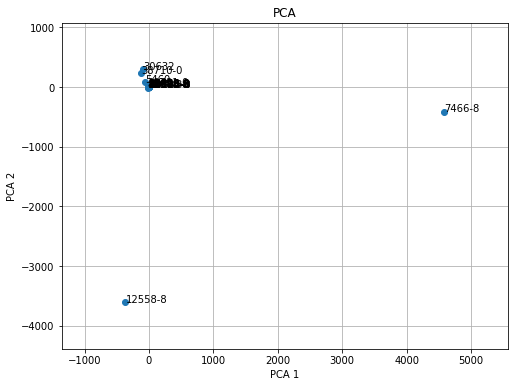

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xmargin(0.2)
ax.set_ymargin(0.2)
ax.scatter(x,y, zorder=3)

# Display titles
for i, title in enumerate(id):
    ax.annotate(title, (x[i]+0.03, y[i]))
    
ax.set(xlabel='PCA 1',
       ylabel='PCA 2', 
       title='PCA')
ax.grid()

plt.show()

# Cluster analysis

## Selecting the number of clusters with silhouette analysis on KMeans clustering

For n_clusters = 2 The average silhouette_score is : 0.86554605
For n_clusters = 3 The average silhouette_score is : 0.88165855
For n_clusters = 4 The average silhouette_score is : 0.8045991
For n_clusters = 5 The average silhouette_score is : 0.7134837
For n_clusters = 6 The average silhouette_score is : 0.649371


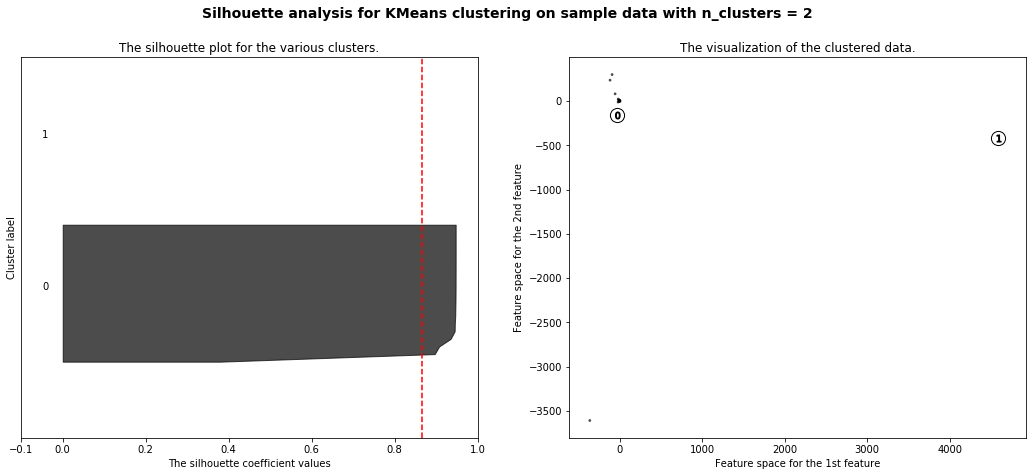

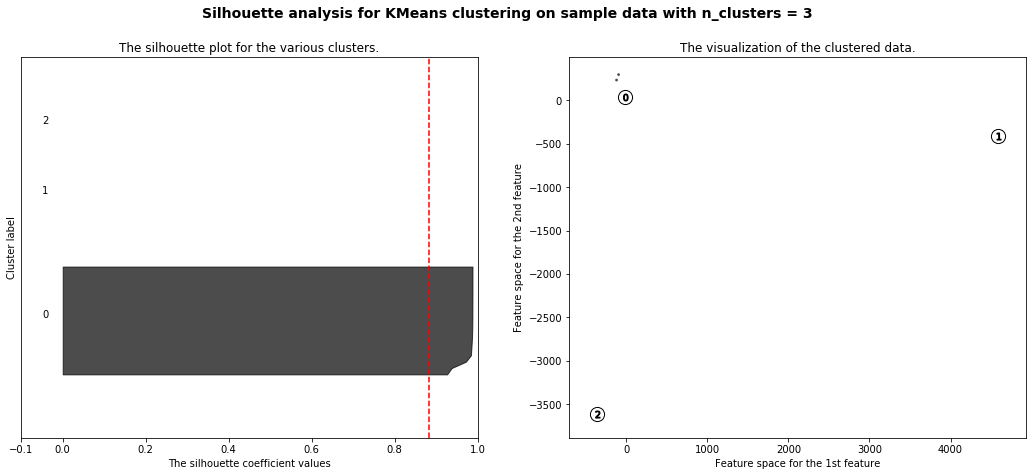

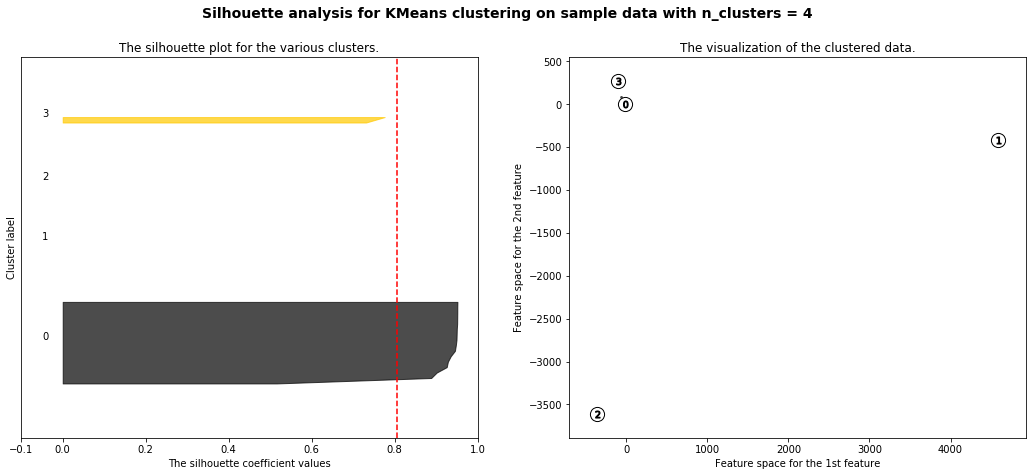

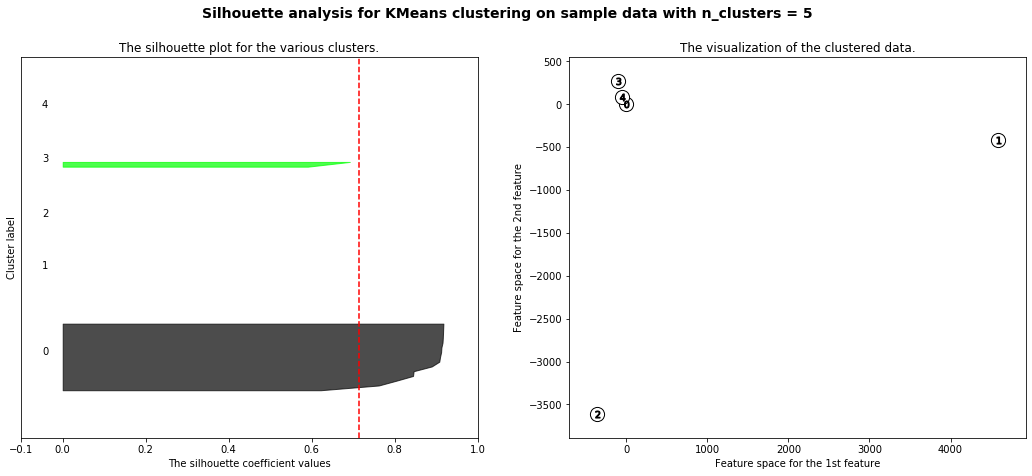

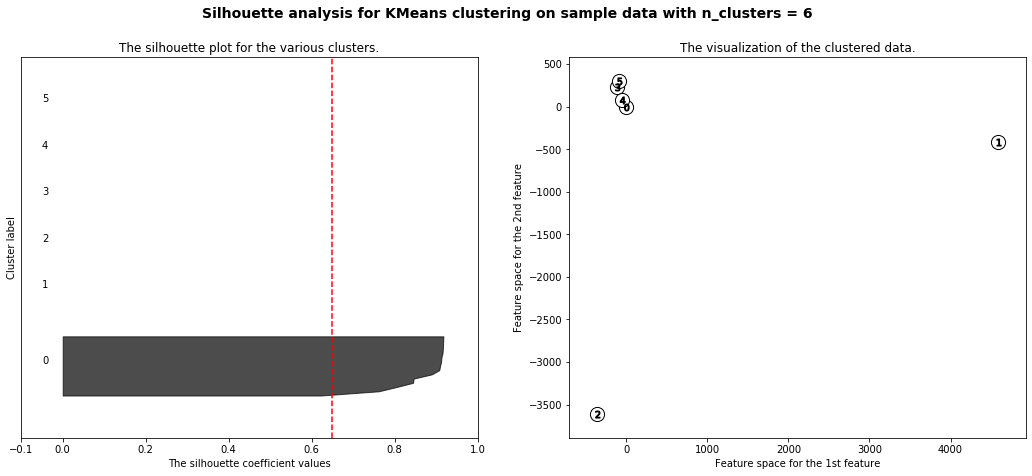

In [22]:
from utils.silhouette_analysis import *

silhouette_plot(plot_df[['PCA_1','PCA_2']].values, range_n_clusters=[2,3,4,5,6])

## Clusterization

In [23]:
from sklearn.cluster import KMeans

clustering_model = KMeans(n_clusters=3,
                          max_iter=100,
                          n_jobs=-1)

labels = clustering_model.fit_predict(plot_df[['PCA_1','PCA_2']].values)

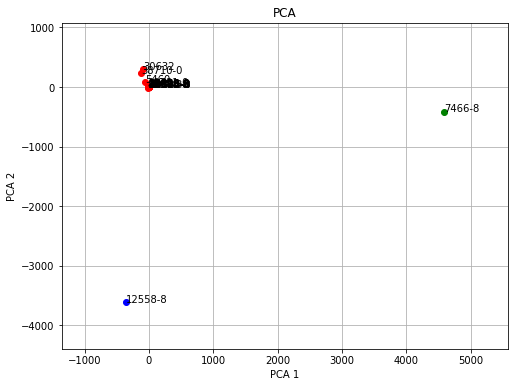

In [25]:
color_map = {0: 'red', 
             1: 'green', 
             2: 'blue'}
    
# titles = ['title_1','title_2','title_3']

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xmargin(0.2)
ax.set_ymargin(0.2)

for i, _ in enumerate(x):
    # Add colors
    color = color_map[labels[i]]
    ax.scatter(x[i], y[i], c=color, zorder=3)
    # Display titles
    ax.annotate(id[i], (x[i]+0.03, y[i]))
    
ax.set(xlabel='PCA 1',
       ylabel='PCA 2', 
       title='PCA')
ax.grid()

plt.show()